In [845]:
import pandas as pd
import numpy as np
import os

import shap
import xgboost as xgb
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_curve, \
roc_auc_score, precision_recall_curve, confusion_matrix, r2_score
import pandas_profiling as pp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


Read the data

In [846]:
!dir data

 Volume in drive C is Windows
 Volume Serial Number is 5441-C8EF

 Directory of C:\Users\bialekj\Documents\Moje\Doktorat wdrozeniowy\wyklady\XAI\pd_2\data

22.03.2020  17:31    <DIR>          .
22.03.2020  17:31    <DIR>          ..
22.03.2020  17:25         2˙452˙351 MEPS_data_preprocessed.csv
               1 File(s)      2˙452˙351 bytes
               2 Dir(s)  66˙651˙029˙504 bytes free


In [847]:
data_dir = 'data'
df = pd.read_csv(os.path.join(data_dir, 'MEPS_data_preprocessed.csv'))
df.reset_index(drop=True, inplace=True)

In [848]:
df.head()

PANEL  REGION  AGE31X  GENDER  RACE3  MARRY31X  EDRECODE  FTSTU31X  \
0     19       2      52     0.0    0.0         5        13        -1   
1     19       2      55     1.0    0.0         3        14        -1   
2     19       2      22     1.0    0.0         5        13         3   
3     19       2       2     0.0    0.0         6        -1        -1   
4     19       3      25     1.0    0.0         1        14        -1   

   ACTDTY31  HONRDC31  ...  PCS42  MCS42  K6SUM42  PHQ242  EMPST31  POVCAT15  \
0         2         2  ...  25.93  58.47        3       0        4         1   
1         2         2  ...  20.42  26.57       17       6        4         3   
2         2         2  ...  53.12  50.33        7       0        1         2   
3         3         3  ...  -1.00  -1.00       -1      -1       -1         2   
4         2         2  ...  59.89  45.91        9       2        1         3   

   INSCOV15  INCOME_M  HEALTHEXP      PERSONWT  
0         2   11390.0      46612  21854.981705  
1         2   11390.0       9207  18169.604822  
2         2   18000.0        808  17191.832515  
3         2     385.0       2721  20261.485463  
4         1    3700.0       1573   7620.222014  

[5 rows x 46 columns]

Change categorical variables to strings (even though they're represented as numbers)

In [849]:
cats = ['REGION','MARRY31X','EDRECODE','FTSTU31X','ACTDTY31','HONRDC31',
            'RTHLTH31','MNHLTH31','HIBPDX','CHDDX','ANGIDX','MIDX','OHRTDX','STRKDX',
            'EMPHDX','CHBRON31','CHOLDX','CANCERDX','DIABDX','JTPAIN31','ARTHDX',
            'ARTHTYPE','ASTHDX','ADHDADDX','PREGNT31','WLKLIM31','ACTLIM31','SOCLIM31',
            'COGLIM31','DFHEAR42','DFSEE42','ADSMOK42','PHQ242','EMPST31','POVCAT15','INSCOV15']

In [850]:
df = df.copy()
for col in cats:
    df[col] = df[col].astype(str) 

In [851]:
# Show summary report
df.profile_report(title='Summary Report')

Let's have a closer look at the predicted variable (HEALTHEXP)

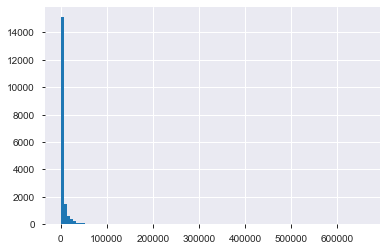

In [852]:
df['HEALTHEXP'].hist(bins=100)

In [853]:
df['HEALTHEXP'].describe(percentiles=np.linspace(0,1,21))

count     18350.000000
mean       5184.511608
std       15126.748532
min           0.000000
0%            0.000000
5%            0.000000
10%           0.000000
15%          20.350000
20%         114.000000
25%         198.000000
30%         302.000000
35%         431.000000
40%         585.000000
45%         779.000000
50%        1034.000000
55%        1339.000000
60%        1784.800000
65%        2343.850000
70%        3099.000000
75%        4219.500000
80%        5619.800000
85%        8137.000000
90%       12591.100000
95%       23417.000000
100%     659952.000000
max      659952.000000
Name: HEALTHEXP, dtype: float64

In [854]:
health_exp = df['HEALTHEXP'].values

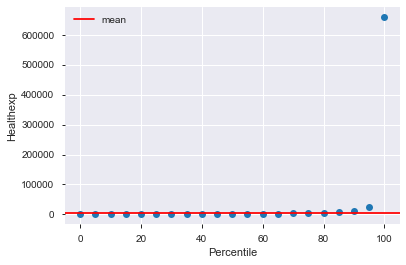

In [855]:
plt.plot(np.linspace(0,100,21), np.percentile(health_exp, np.linspace(0,100,21)),'o');
plt.axhline(y=np.mean(health_exp), color='red', label = 'mean')
plt.xlabel('Percentile');
plt.ylabel('Healthexp');
plt.legend();

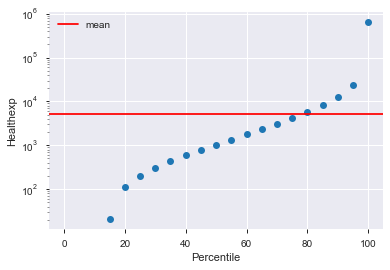

In [856]:
plt.plot(np.linspace(0,100,21), np.percentile(health_exp, np.linspace(0,100,21)),'o');
plt.axhline(y=np.mean(health_exp), color='red', label = 'mean')
plt.xlabel('Percentile');
plt.ylabel('Healthexp');
plt.yscale('log')
plt.legend();

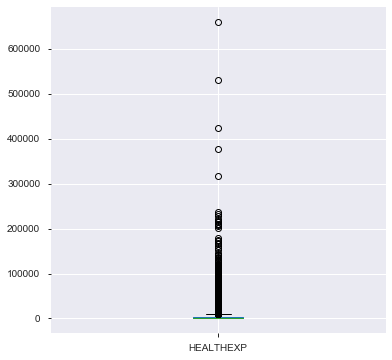

In [857]:
plt.figure(figsize=(6,6))
df[['HEALTHEXP']].boxplot();

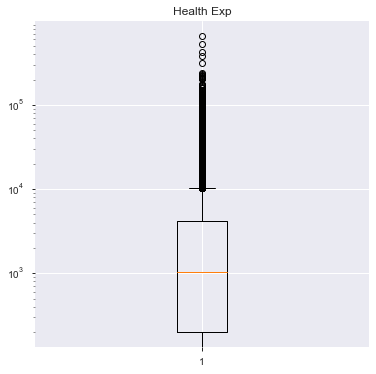

In [858]:
plt.figure(figsize=(6,6))
plt.boxplot(df['HEALTHEXP']);
plt.title('Health Exp')
plt.yscale('log')

Notes on predicted variable:
* 14.3 % of observations are equal to 0.
* The distribution is positevely skewed with many high-value outliers (very high treatment costs).
* About 80 % of observations are below the mean. Std is three times higher than  the mean.

Prepare features

In [859]:
# Drop panel number (not meant to be predictive) and sample weights
df.drop(columns = ['PANEL', 'PERSONWT'], inplace=True)
df.head()

REGION  AGE31X  GENDER  RACE3 MARRY31X EDRECODE FTSTU31X ACTDTY31 HONRDC31  \
0      2      52     0.0    0.0        5       13       -1        2        2   
1      2      55     1.0    0.0        3       14       -1        2        2   
2      2      22     1.0    0.0        5       13        3        2        2   
3      2       2     0.0    0.0        6       -1       -1        3        3   
4      3      25     1.0    0.0        1       14       -1        2        2   

  RTHLTH31  ... ADSMOK42  PCS42  MCS42 K6SUM42 PHQ242 EMPST31 POVCAT15  \
0        4  ...        2  25.93  58.47       3      0       4        1   
1        4  ...        2  20.42  26.57      17      6       4        3   
2        1  ...        2  53.12  50.33       7      0       1        2   
3        1  ...       -1  -1.00  -1.00      -1     -1      -1        2   
4        1  ...        2  59.89  45.91       9      2       1        3   

  INSCOV15 INCOME_M HEALTHEXP  
0        2  11390.0     46612  
1        2  11390.0      9207  
2        2  18000.0       808  
3        2    385.0      2721  
4        1   3700.0      1573  

[5 rows x 44 columns]

In [860]:
y = df.pop('HEALTHEXP')

One-hot encoding for all the categorical features 

In [861]:
for col in cats:
    var_one_hot = pd.get_dummies(df[col],prefix=col, drop_first = True)
    df = df.drop(columns=[col])
    df = pd.concat([df, var_one_hot], axis=1)

In [862]:
df.head()

AGE31X  GENDER  RACE3  PCS42  MCS42  K6SUM42  INCOME_M  REGION_2  REGION_3  \
0      52     0.0    0.0  25.93  58.47        3   11390.0         1         0   
1      55     1.0    0.0  20.42  26.57       17   11390.0         1         0   
2      22     1.0    0.0  53.12  50.33        7   18000.0         1         0   
3       2     0.0    0.0  -1.00  -1.00       -1     385.0         1         0   
4      25     1.0    0.0  59.89  45.91        9    3700.0         0         1   

   REGION_4  ...  EMPST31_1  EMPST31_2  EMPST31_3  EMPST31_4  POVCAT15_2  \
0         0  ...          0          0          0          1           0   
1         0  ...          0          0          0          1           0   
2         0  ...          1          0          0          0           1   
3         0  ...          0          0          0          0           1   
4         0  ...          1          0          0          0           0   

   POVCAT15_3  POVCAT15_4  POVCAT15_5  INSCOV15_2  INSCOV15_3  
0           0           0           0           1           0  
1           1           0           0           1           0  
2           0           0           0           1           0  
3           0           0           0           1           0  
4           1           0           0           0           0  

[5 rows x 110 columns]

More feature engineering in next HW ...

In [931]:
def train_print_save_models_reg(mods, dfTrain, dfTest, yTrain, yTest):
    trained_models = {}
    for model_name, mod_object in mods.items():
        md = mod_object.fit(dfTrain,yTrain)
        y_pred_test = md.predict(dfTest)
        y_pred_test[y_pred_test<0]=0
        y_pred_train = md.predict(dfTrain)
        print(model_name)
        print('Training R^2:', r2_score(yTrain, y_pred_train))
        print('Test R^2:', r2_score(yTest, y_pred_test))
        trained_models[model_name] = md
    return trained_models       
    

In [932]:
def train_print_save_models_clf(mods, dfTrain, dfTest, yTrain, yTest):
    trained_models = {}
    for model_name, mod_object in mods.items():
        md = mod_object.fit(dfTrain,yTrain)
        y_pred_test = md.predict(dfTest)
        y_pred_train = md.predict(dfTrain)
        
        accuracy_train = accuracy_score(yTrain,y_pred_train)
        AUROC_train = roc_auc_score(yTrain,y_pred_train)
        
        accuracy_test = accuracy_score(yTest,y_pred_test)
        AUROC_test = roc_auc_score(yTest,y_pred_test)
        
        print(model_name)
        print('Train - accuracy:{}, AUROC:{}'.format( 
              accuracy_train, AUROC_train))
        print('Test - accuracy:{}, AUROC:{}'.format(
              accuracy_test, AUROC_test))

        trained_models[model_name] = md
    return trained_models       

In [933]:
mods = {
    'XGB':xgb.XGBRegressor(max_depth=2),
    'LinReg':LinearRegression(),
    'Ridge_Reg':Ridge(alpha=.5)
}

In [934]:
dfTrain, dfTest, yTrain, yTest = train_test_split(df, y, random_state=42)

In [935]:
len(dfTrain), len(dfTest)

(13762, 4588)

In [936]:
models = train_print_save_models_reg(mods, dfTrain, dfTest, yTrain, yTest)

XGB
Training R^2: 0.3144838537481811
Test R^2: 0.10834912625808713
LinReg
Training R^2: 0.16860735843404706
Test R^2: 0.1420705069755105
Ridge_Reg
Training R^2: 0.1686004595670868
Test R^2: 0.14179963621667757


HW 2:
#### For the selected data set, train at least one tree-based ensemble model (random forest, gbm, catboost or any other boosting)

In [937]:
model1 = models['XGB']
model1

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.300000012, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
       validate_parameters=False, verbosity=None)

#### For some selected observation from this dataset, calculate the model predictions for model (1)

In [938]:
obs = dfTest.sample(random_state = 42)
idx = obs.index
obs

AGE31X  GENDER  RACE3  PCS42  MCS42  K6SUM42  INCOME_M  REGION_2  \
10708      40     1.0    0.0  36.47  49.91        0   48095.0         0   

       REGION_3  REGION_4  ...  EMPST31_1  EMPST31_2  EMPST31_3  EMPST31_4  \
10708         1         0  ...          1          0          0          0   

       POVCAT15_2  POVCAT15_3  POVCAT15_4  POVCAT15_5  INSCOV15_2  INSCOV15_3  
10708           0           0           1           0           0           0  

[1 rows x 110 columns]

In [939]:
pred = model1.predict(obs)[0]
real = yTest[idx].values[0]
print('Prediction for selected observeation =', pred)
print('While the actual value = ', real)

Prediction for selected observeation = 3535.9656
While the actual value =  25424


#### For an observation selected in (2), calculate the decomposition of model prediction using SHAP, Break Down or both (packages for R: DALEX, iml, packages for python: shap, dalex, piBreakDown).

In [940]:
def show_shap_for_obs(obs, model, model_type, reference=None):
    if model_type == 'Tree':
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(obs)[0]
        shap.waterfall_plot(explainer.expected_value, shap_values,
                            feature_names=list(obs.columns))
    else:
        explainer = shap.KernelExplainer(model.predict, reference)
        shap_values = explainer.shap_values(obs)[0]
        plot = shap.waterfall_plot(explainer.expected_value, shap_values,
                                   feature_names=list(obs.columns))


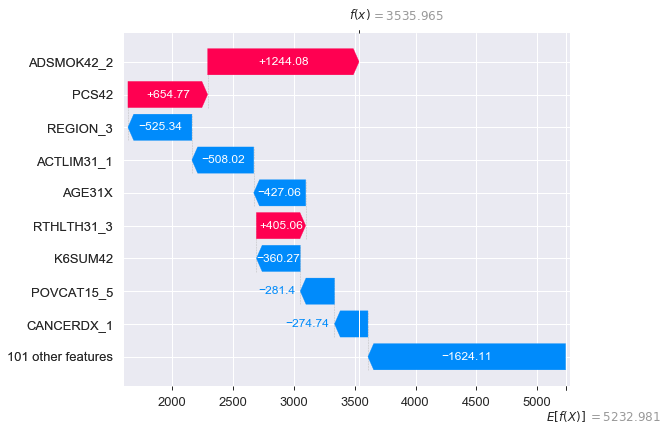

In [941]:
show_shap_for_obs(obs, model1, 'Tree')

#### Find two observations in the data set, such that they have different most important variables (e.g. age and gender are the most important for observation A, but race and class for observation B)

In [942]:
obs2 = dfTest.sample(random_state = 23)
obs2

AGE31X  GENDER  RACE3  PCS42  MCS42  K6SUM42  INCOME_M  REGION_2  \
5764      59     0.0    0.0  46.69  56.95        2   16000.0         0   

      REGION_3  REGION_4  ...  EMPST31_1  EMPST31_2  EMPST31_3  EMPST31_4  \
5764         0         0  ...          1          0          0          0   

      POVCAT15_2  POVCAT15_3  POVCAT15_4  POVCAT15_5  INSCOV15_2  INSCOV15_3  
5764           0           1           0           0           0           0  

[1 rows x 110 columns]

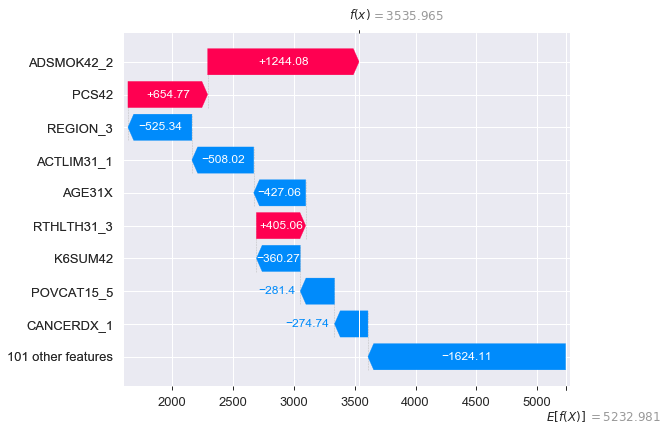

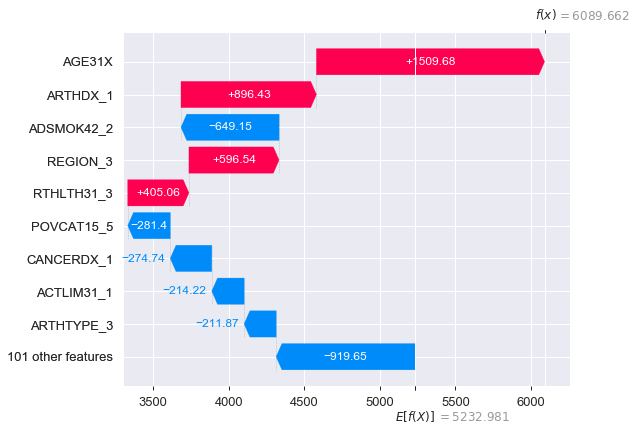

In [943]:
show_shap_for_obs(obs, model1, 'Tree')
show_shap_for_obs(obs2, model1, 'Tree')

In [956]:
for col in ['AGE31X','ADSMOK42_2']:
    print(col+' Patient 1: {}, Patient 2:{}'.format(obs[col].values[0], obs2[col].values[0]))

AGE31X Patient 1: 40, Patient 2:59
ADSMOK42_2 Patient 1: 1, Patient 2:0


In the first observation, ADSMOK42_2 is the most important feature, while in the second AGE31X. The patient from first observation is 40 and is a smoker, while the other is 59 (considerably older) and non-smoking. 

#### Select one variable and find two observations in the data set such that for one observation this variable has a positive effect and for the other a negative effect

Age may be a good shot. Let's give it a try

In [944]:
obs3 = dfTest[dfTest['AGE31X']<10].sample(random_state = 23)

In [945]:
obs3

AGE31X  GENDER  RACE3  PCS42  MCS42  K6SUM42  INCOME_M  REGION_2  \
15628       4     1.0    0.0   -1.0   -1.0       -1       0.0         1   

       REGION_3  REGION_4  ...  EMPST31_1  EMPST31_2  EMPST31_3  EMPST31_4  \
15628         0         0  ...          0          0          0          0   

       POVCAT15_2  POVCAT15_3  POVCAT15_4  POVCAT15_5  INSCOV15_2  INSCOV15_3  
15628           0           0           1           0           0           0  

[1 rows x 110 columns]

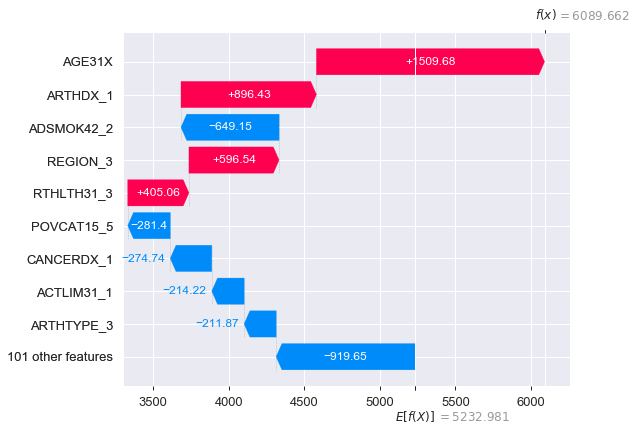

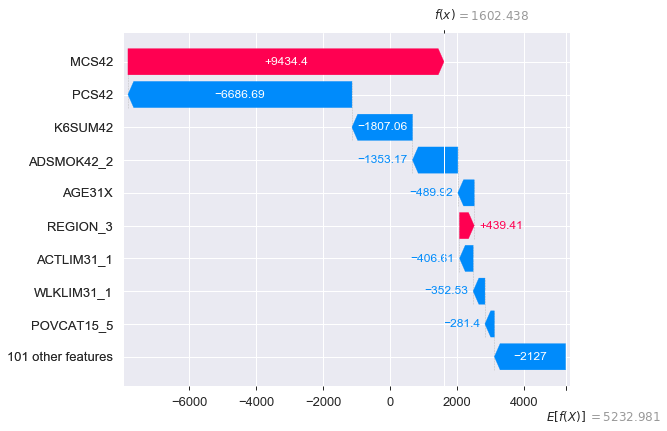

In [946]:
show_shap_for_obs(obs2, model1, 'Tree')
show_shap_for_obs(obs3, model1, 'Tree')

For the 59 yr old patient age has positive impact (+1509.68). The patient for which the age has negative effect (-489.92) on the prediction is very young (4 years old) thus most likely is not severely ill.

#### Train a second model (of any class, neural nets, linear, other boosting) and find an observation for which BD/shap attributions are different between the models

In [947]:
model2 = models['LinReg']

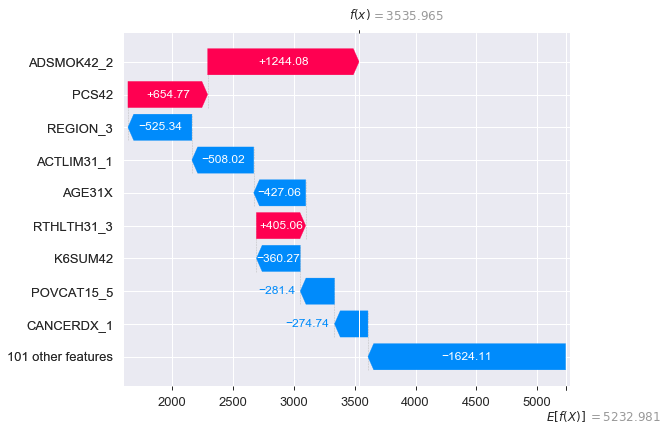

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

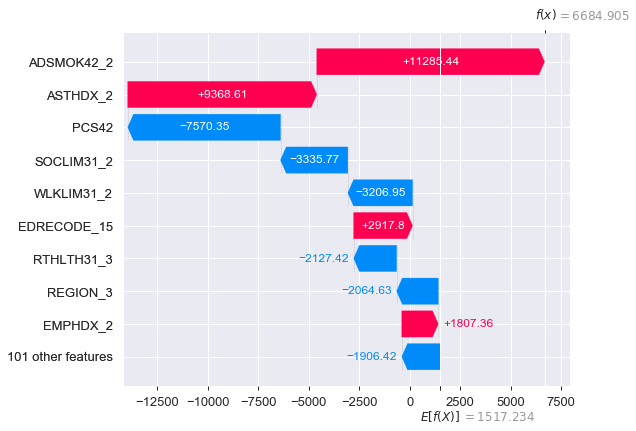

In [950]:
show_shap_for_obs(obs, model1, 'Tree')
show_shap_for_obs(obs, model2, 'Linear', reference=np.zeros((1,len(obs.columns))))


For the same observation, different models give different effects for the same variables. While for both models ADSMOK42_2 has positive effect (increases the treatment costs), PCS42 have positie effect in one model and negative effect in the other.

Extras, don't check.


Just out of curiosity - lets do this again, with standarized features

In [882]:
dfTrain, dfTest, yTrain, yTest = train_test_split(df, y, random_state=42)

In [883]:
scaler = StandardScaler()
scaler.fit(dfTrain)
X_train = scaler.transform(dfTrain)
X_test = scaler.transform(dfTest)

In [884]:
models = train_print_save_models_reg(mods, X_train, X_test, yTrain, yTest)

XGB
Training R^2: 0.3144838537481811
Test R^2: 0.10737233183653594
LinReg
Training R^2: 0.16841122794211272
Test R^2: 0.14109309324760344
Ridge_Reg
Training R^2: 0.16860724420372686
Test R^2: 0.13987204406049225


In [885]:
model = models['LinReg']

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

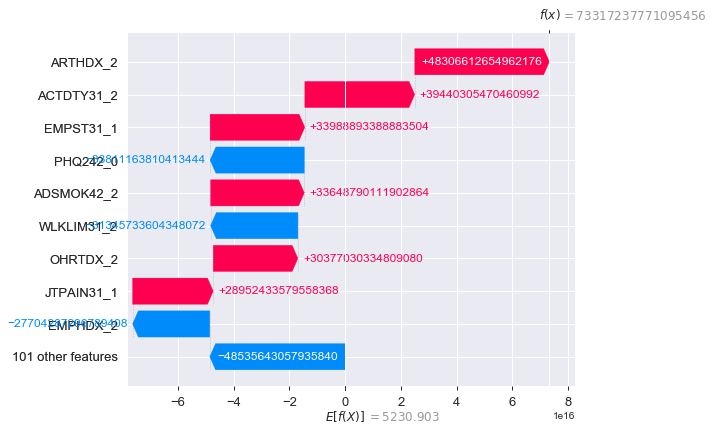

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

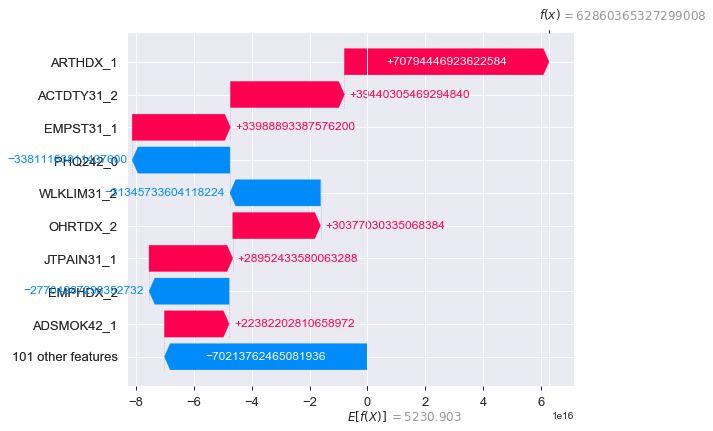

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

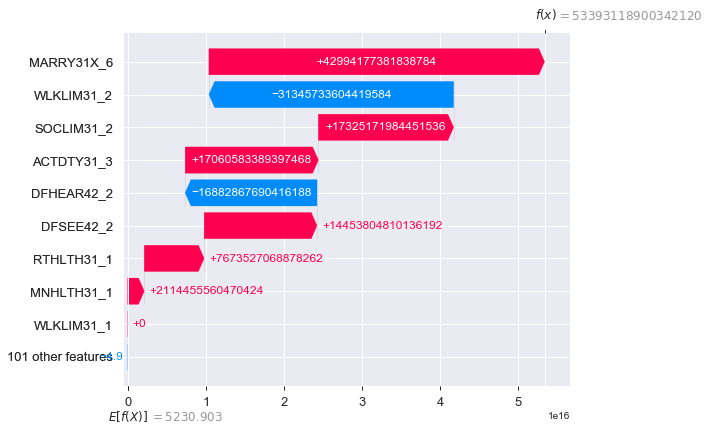

In [886]:
show_shap_for_obs(obs, model, 'Linear', reference=np.zeros((1,len(obs.columns))))
show_shap_for_obs(obs2, model, 'Linear', reference=np.zeros((1,len(obs.columns))))
show_shap_for_obs(obs3, model, 'Linear', reference=np.zeros((1,len(obs.columns))))

In [887]:
model.intercept_

5230.903480433291

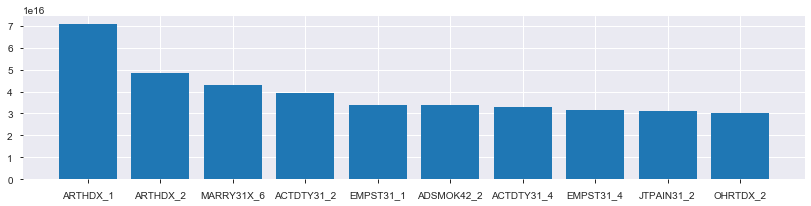

In [888]:
coefs = model.coef_
max_ten = coefs.argsort()[-10:][::-1]
max_ten_vals = coefs[max_ten]
plt.figure(figsize=(14,3))
plt.bar(range(10),max_ten_vals)
plt.xticks(range(10), list(obs.columns[[max_ten]]));